# EVALUATING LOGISTIC REGRESSION MODEL

In [1]:
import numpy as np
from collections import Counter
import chardet
import math
import re
import libnum
import random

np.random.seed(12345)

def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        raw_data = f.read()
        result = chardet.detect(raw_data)
        return result['encoding']

def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'&\w+;', '', text)
    text = re.sub(r'Subject:', '', text)
    return text
    
def load_data(file_path):
    print(f"Detecting Encoding for {file_path}...")
    encoding = detect_encoding(file_path)
    print(f"Encoding detected: {encoding}\n")

    print(file_path, " : ", encoding) 
    with open(file_path, 'r', encoding=encoding, errors='replace') as f:
        raw = f.readlines()
    print(f"Dataset '{file_path}' loaded successfully with {len(raw)} records.\n")
    return [[word for word in clean_text(row).split() if word.strip()] for row in raw]

spam = load_data('spam.txt')
ham = load_data('ham.txt')

def mod_inverse(x, n):
    return pow(x, -1, n)

def L(x, n):
    return (x - 1) // n

def generate_keys(bit_length=256):
    print("Generating keys, please wait...")

    p = libnum.generate_prime(bit_length // 2)
    q = libnum.generate_prime(bit_length // 2)
    n = p * q
    n_sq = n * n
    lambda_param = (p - 1) * (q - 1) // math.gcd(p - 1, q - 1)
    g = n + 1
    mu = mod_inverse(L(pow(g, lambda_param, n_sq), n), n)
    print(f"Keys generated successfully! (bit length: {bit_length})\n")

    public_key = (n, g)
    private_key = (lambda_param, mu)
    return public_key, private_key

split_idx_spam = int(0.8 * len(spam))
split_idx_ham = int(0.8 * len(ham))

train_spam, val_spam = spam[:split_idx_spam], spam[split_idx_spam:]
train_ham, val_ham = ham[:split_idx_ham], ham[split_idx_ham:]

class EncryptedNumber:
    def __init__(self, ciphertext):
        self.ciphertext = ciphertext

def encrypt(public_key, plaintext, scaling_factor=1000):
    n, g = public_key
    n_sq = n * n
    r = libnum.randint_bits(n.bit_length() - 1) % n
    ciphertext = (pow(g, int(plaintext * scaling_factor), n_sq) * pow(r, n, n_sq)) % n_sq
    return EncryptedNumber(ciphertext)

def decrypt(private_key, public_key, encrypted_number, scaling_factor=1000):
    n, g = public_key
    lambda_param, mu = private_key
    n_sq = n * n
    ciphertext = encrypted_number.ciphertext
    x = pow(ciphertext, lambda_param, n_sq)
    plaintext = (L(x, n) * mu) % n
    return plaintext / scaling_factor

def homomorphic_add(public_key, c1, c2):
    n, _ = public_key
    n_sq = n * n
    return EncryptedNumber((c1.ciphertext * c2.ciphertext) % n_sq)

class LogisticRegression:
    def __init__(self, positives, negatives, public_key, val_pos, val_neg, iterations=20, alpha=0.01, regularization_strength=0.02, weight_scale=1e3, noise_factor=0.01):
        self.alpha = alpha
        self.regularization_strength = regularization_strength
        self.pubkey = public_key
        self.weight_scale = weight_scale
        self.noise_factor = noise_factor

        # Initialize storage for losses and accuracies
        self.train_loss = []
        self.val_loss = []
        self.train_accuracy = []
        self.val_accuracy = []

        # Initialize vocabulary and weights
        cnts = Counter()
        for email in (positives + negatives):
            cnts.update(email)
        vocab = list(cnts.keys())
        self.word2index = {word: i for i, word in enumerate(vocab)}
        self.weights = (np.random.rand(len(vocab)) - 0.5) * 0.1

        self.train(positives, negatives, val_pos, val_neg, iterations=iterations)

    def train(self, positives, negatives, val_pos, val_neg, iterations=10):
        for iteration in range(iterations):
            train_loss = 0
            n = 0

            # Training phase
            for i in range(max(len(positives), len(negatives))):
                noisy_target_pos = 1 if random.random() > self.noise_factor else 0
                noisy_target_neg = 0 if random.random() > self.noise_factor else 1

                train_loss += np.abs(self.learn(positives[i % len(positives)], noisy_target_pos))
                train_loss += np.abs(self.learn(negatives[i % len(negatives)], noisy_target_neg))
                n += 2

            # Average training loss
            train_loss /= n
            self.train_loss.append(train_loss)

            # Validation phase
            val_loss = 0
            correct_predictions = 0
            total_predictions = len(val_pos) + len(val_neg)

            for email in val_pos:
                pred = self.predict(email, encrypt_output=False)
                val_loss += np.abs(pred - 1)
                correct_predictions += int(pred == 1)

            for email in val_neg:
                pred = self.predict(email, encrypt_output=False)
                val_loss += np.abs(pred - 0)
                correct_predictions += int(pred == 0)

            # Average validation loss
            val_loss /= total_predictions
            self.val_loss.append(val_loss)

            # Calculate validation accuracy
            val_accuracy = correct_predictions / total_predictions
            self.val_accuracy.append(val_accuracy)

            print(f"Iteration: {iteration + 1}, Training Loss: {train_loss:.10f}, Validation Loss: {val_loss:.10f}, Validation Accuracy: {val_accuracy:.2%}")


    @staticmethod
    def softmax(x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def predict(self, email, encrypt_output=True):
        # Create a sparse feature vector for the email
        feature_vector = np.zeros(len(self.weights))
        
        for word in email:
            if word in self.word2index:
                feature_vector[self.word2index[word]] = 1
        
        # Calculate the weighted sum (dot product)
        pred = np.dot(self.weights, feature_vector)
        pred = self.softmax(pred)
        
        if encrypt_output:
            return encrypt(self.pubkey, pred)
        
        return 1 if pred >= 0.5 else 0


    def learn(self, email, target):
        pred = self.predict(email, encrypt_output=False)  # Unencrypted prediction
        delta = pred - target  # This operation works because `pred` is unencrypted
    
        for word in email:
            if word in self.word2index:
                self.weights[self.word2index[word]] -= self.alpha * (delta + self.regularization_strength * self.weights[self.word2index[word]])

        return delta


# Example Usage
if __name__ == "__main__":
    public_key, private_key = generate_keys(bit_length=128)
    model = LogisticRegression(spam[0:-1000], ham[0:-1000], public_key, val_pos=val_spam, val_neg=val_ham, iterations=10, alpha=0.001)

    fp, tn, tp, fn = 0, 0, 0, 0

    for h in ham[-1000:]:
        pred = model.predict(h, encrypt_output=False)  # Encrypt the output during prediction
        #pred = decrypt(private_key, public_key, encrypted_pred)
        if pred <  0.5:
            tn += 1
        else:
            fp += 1

    for s in spam[-1000:]:
        pred = model.predict(s, encrypt_output=False)  # Encrypt the output during prediction
        #pred = decrypt(private_key, public_key, encrypted_pred)
        if pred > 0.5:
            tp += 1
        else:
            fn += 1

print(f"False Positives: {fp}, True Negatives: {tn}, True Positives: {tp}, False Negatives: {fn}")
accuracy = 100 * (tn + tp) / (tn + tp + fp + fn) if (tn + tp + fp + fn) > 0 else 0
print(f"\nAccuracy: {accuracy:.2f}%")


Detecting Encoding for spam.txt...
Encoding detected: Windows-1252

spam.txt  :  Windows-1252
Dataset 'spam.txt' loaded successfully with 9000 records.

Detecting Encoding for ham.txt...
Encoding detected: ascii

ham.txt  :  ascii
Dataset 'ham.txt' loaded successfully with 22032 records.

Generating keys, please wait...
Keys generated successfully! (bit length: 128)

Iteration: 1, Training Loss: 0.0800446938, Validation Loss: 0.0306106009, Validation Accuracy: 96.94%
Iteration: 2, Training Loss: 0.0376093572, Validation Loss: 0.0288384082, Validation Accuracy: 97.12%
Iteration: 3, Training Loss: 0.0359452263, Validation Loss: 0.0082165297, Validation Accuracy: 99.18%
Iteration: 4, Training Loss: 0.0402244199, Validation Loss: 0.0240051555, Validation Accuracy: 97.60%
Iteration: 5, Training Loss: 0.0386078357, Validation Loss: 0.0330272273, Validation Accuracy: 96.70%
Iteration: 6, Training Loss: 0.0261506276, Validation Loss: 0.0061221202, Validation Accuracy: 99.39%
Iteration: 7, Trai

In [11]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_loss(training_losses, validation_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Iterations')
    plt.legend()
    plt.show()


def plot_accuracy(train_accuracy, val_accuracy):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Over Iterations')
    plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return precision, recall, f1

def plot_metrics(accuracy, precision, recall, f1):
    # Create a bar plot of the metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [accuracy, precision, recall, f1]

    plt.figure(figsize=(8, 6))
    plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
    plt.ylim(0, 1)
    plt.title("Model Performance Metrics")
    plt.ylabel("Score")
    plt.show()

def plot_confusion_matrix(tn, fp, fn, tp):
    # Create a confusion matrix array
    confusion_matrix = np.array([[tn, fp], [fn, tp]])
    labels = np.array([["True Negative", "False Positive"], ["False Negative", "True Positive"]])

    # Use Seaborn's heatmap to plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix, annot=labels, fmt="", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


Iteration: 1, Training Loss: 0.0999716312, Validation Loss: 0.0260995650, Validation Accuracy: 97.39%
Iteration: 2, Training Loss: 0.0645106383, Validation Loss: 0.0346383116, Validation Accuracy: 96.54%
Iteration: 3, Training Loss: 0.0507234043, Validation Loss: 0.0228773965, Validation Accuracy: 97.71%
Iteration: 4, Training Loss: 0.0469219858, Validation Loss: 0.0533268890, Validation Accuracy: 94.67%
Iteration: 5, Training Loss: 0.0397730496, Validation Loss: 0.0138553246, Validation Accuracy: 98.61%
Iteration: 6, Training Loss: 0.0216170213, Validation Loss: 0.0190107943, Validation Accuracy: 98.10%
Iteration: 7, Training Loss: 0.0300425532, Validation Loss: 0.0048332528, Validation Accuracy: 99.52%
Iteration: 8, Training Loss: 0.0219007092, Validation Loss: 0.0647655872, Validation Accuracy: 93.52%
Iteration: 9, Training Loss: 0.0255035461, Validation Loss: 0.0025777348, Validation Accuracy: 99.74%
Iteration: 10, Training Loss: 0.0440851064, Validation Loss: 0.0489769615, Validat

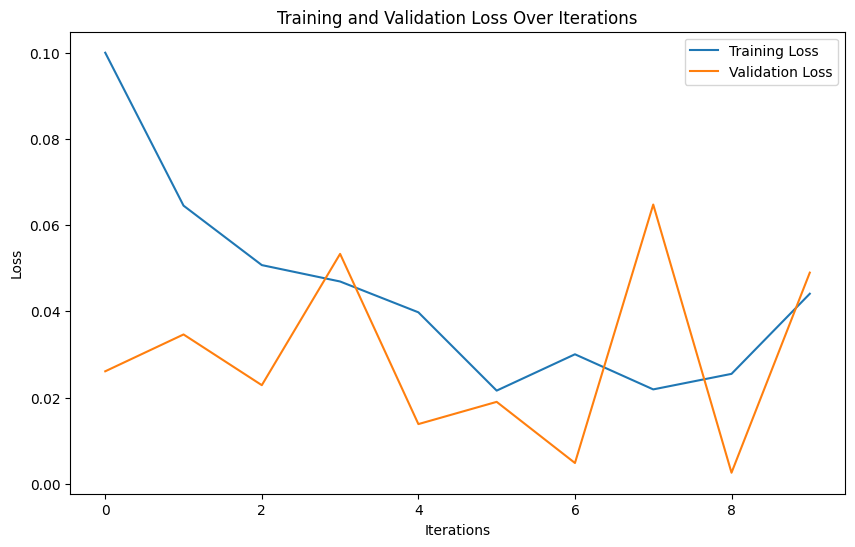

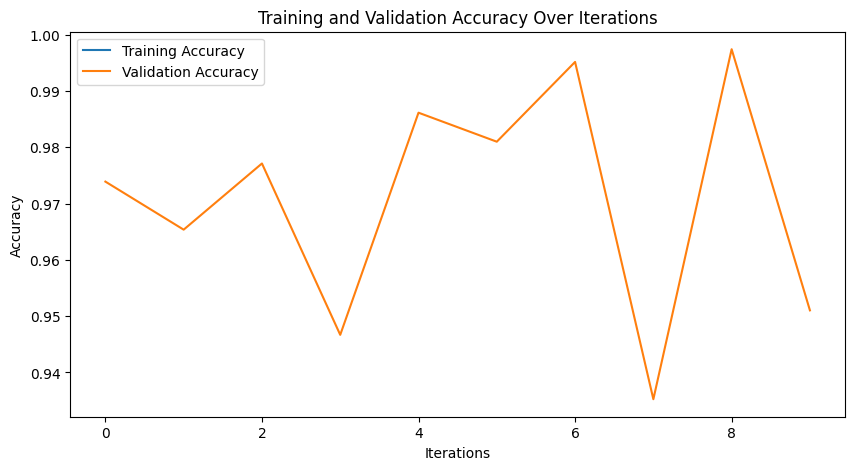

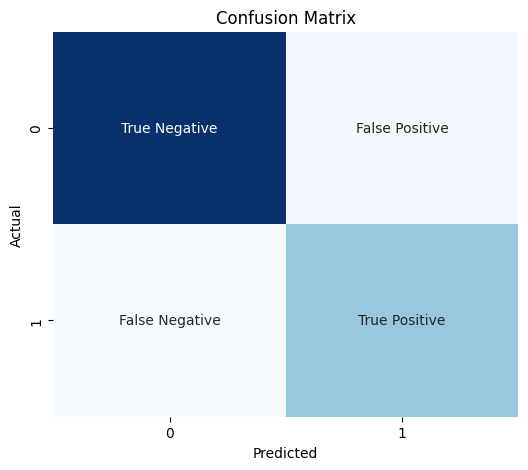

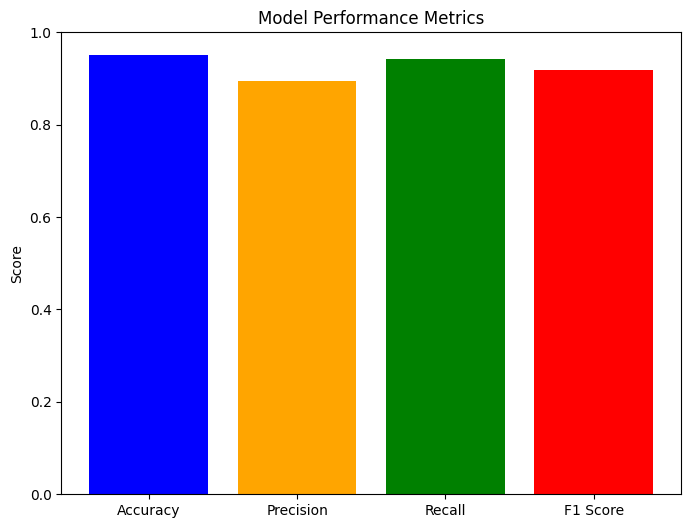

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Train the model
model = LogisticRegression(train_spam, train_ham, public_key, val_pos=val_spam, val_neg=val_ham, iterations=10, alpha=0.001)

# Plotting loss and accuracy over iterations
def plot_loss_and_accuracy():
    # Assuming `model.train_loss` and `model.val_loss` are being stored during training
    plot_loss(model.train_loss, model.val_loss)

    # Assuming `model.train_accuracy` and `model.val_accuracy` are calculated during training
    plot_accuracy(model.train_accuracy, model.val_accuracy)

plot_loss_and_accuracy()

# Calculate metrics on validation data
def calculate_and_plot_metrics():
    y_true = [0]*len(val_ham) + [1]*len(val_spam)  # True labels
    y_pred = []

    for h in val_ham:
        pred = model.predict(h, encrypt_output=False)
        y_pred.append(pred)

    for s in val_spam:
        pred = model.predict(s, encrypt_output=False)
        y_pred.append(pred)

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate accuracy, precision, recall, and F1-score
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    # Plot confusion matrix
    plot_confusion_matrix(tn, fp, fn, tp)
    
    # Plot metrics (Accuracy, Precision, Recall, F1)
    plot_metrics(accuracy, precision, recall, f1)

calculate_and_plot_metrics()
